In [1]:
import numpy as np
import pandas as pd

In [2]:
from tqdm.auto import tqdm
tqdm.pandas()

/home/daniel/miniconda3/envs/pytorch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv('parma_crescent_prices.csv')

In [4]:
df.displayPrice = pd.to_numeric(df.displayPrice.str.replace('£', '').str.replace(',', ''))

In [5]:
df.dateSold = pd.to_datetime(df.dateSold)

In [6]:
df = df.sort_values('dateSold').reset_index(drop=True)

In [7]:
import seaborn as sns

<Axes: xlabel='dateSold', ylabel='displayPrice'>

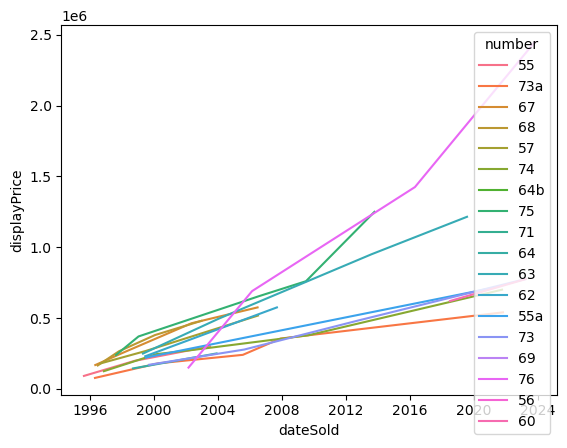

In [8]:
sns.lineplot(data=df, x='dateSold', y='displayPrice', hue='number')

In [9]:
number_to_idx = {number: i for i, number in enumerate(df.number.sort_values().drop_duplicates())}
df['number_idx'] = df.number.apply(lambda x: number_to_idx[x])

In [10]:
import torch

price_tensor = torch.tensor(np.atleast_2d(df.displayPrice.head(-1).to_numpy().reshape(len(df.index)-1, 1)), dtype=torch.float32).to('cuda:0')
number_tensor = torch.tensor(np.atleast_2d(df.number_idx.tail(-1).to_numpy().reshape(len(df.index)-1, 1))).to('cuda:0')
y_tensor = torch.tensor(np.atleast_2d(df.displayPrice.tail(-1).to_numpy().reshape(len(df.index)-1, 1)), dtype=torch.float32).to('cuda:0')

In [11]:
number_tensor.shape, price_tensor.shape, y_tensor.shape

(torch.Size([52, 1]), torch.Size([52, 1]), torch.Size([52, 1]))

In [12]:
price_mean = price_tensor.mean()
price_std = price_tensor.std()

In [13]:
price_tensor = (price_tensor - price_mean) / price_std
y_tensor = (y_tensor - price_mean) / price_std

In [14]:
import torch.nn as nn

class MaskedLSTMModel(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, output_size):
        super(MaskedLSTMModel, self).__init__()
        self.embeddings = nn.Embedding(input_size, embedding_size)
        self.lstm = nn.LSTM(1, hidden_size)
        self.fc = nn.Linear(embedding_size + hidden_size, output_size)

    def forward(self, numbers, prices):

        out, _ = self.lstm(prices)
        embeds = self.embeddings(numbers).view(len(numbers), -1)
        concat = torch.concat([out, embeds], axis=1)
        out = self.fc(concat)
        return out

In [15]:
INPUT_SIZE = len(number_tensor.unique())
EMBEDDING_SIZE = 1
HIDDEN_SIZE = 1
OUTPUT_SIZE = 1

In [16]:
import torch.optim as optim
import torch.nn.functional as F

model = MaskedLSTMModel(INPUT_SIZE, EMBEDDING_SIZE, HIDDEN_SIZE, OUTPUT_SIZE).to('cuda:0')
loss_function = nn.NLLLoss().to('cuda:0')
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# See what the scores are before training
# Note that element i,j of the output is the score for tag j for word i.
# Here we don't need to train, so the code is wrapped in torch.no_grad()
with torch.no_grad():
    pred = model(number_tensor, price_tensor)
    #print(pred)

losses = []
def inter_epoch(i):  # again, normally you would NOT do 300 epochs, it is toy data
    # Step 1. Remember that Pytorch accumulates gradients.
    # We need to clear them out before each instance
    model.zero_grad()

    # Step 2. Get our inputs ready for the network, that is, turn them into
    # Tensors of word indices.
    #sentence_in = prepare_sequence(sentence, word_to_ix)
    #targets = prepare_sequence(tags, tag_to_ix)

    # Step 3. Run our forward pass.
    pred = model(number_tensor, price_tensor)
    
    # Step 4. Compute the loss, gradients, and update the parameters by
    #  calling optimizer.step()
    loss = F.mse_loss(pred, y_tensor)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    if i % 10000 == 9999: 
        ax = sns.lineplot(losses)
        ax.set(yscale='log')
        fig = ax.get_figure()
        fig.savefig('losses.png')
        fig.clf()
        pred = (pred.detach() * price_std) + price_mean
        ax = sns.lineplot(pred.to('cpu'), legend=None)
        fig = ax.get_figure()
        fig.savefig('pred.png')
        fig.clf()

pd.Series(range(100000)).progress_apply(inter_epoch)

# See what the scores are after training
with torch.no_grad():
    pred = model(number_tensor, price_tensor)
    #print(pred)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [01:31<00:00, 1098.05it/s]


<Figure size 640x480 with 0 Axes>

[None]

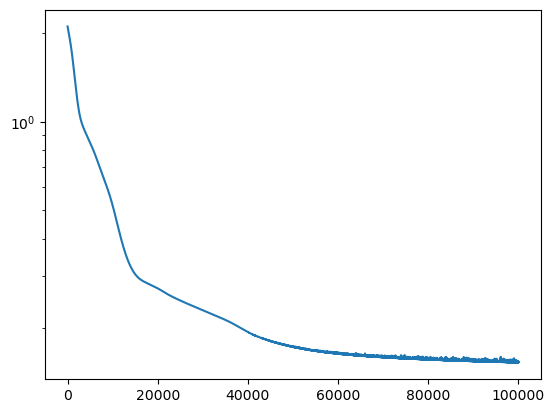

In [17]:
sns.lineplot(losses).set(yscale='log')

In [18]:
y_tensor = (y_tensor.detach() * price_std) + price_mean

<Axes: >

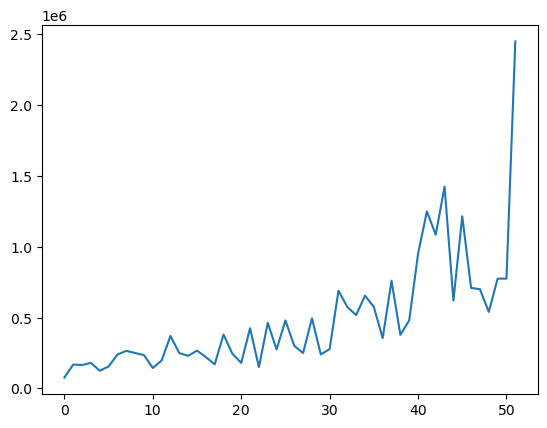

In [19]:
sns.lineplot(y_tensor.to('cpu'), legend=None)

In [20]:
pred = (pred.detach() * price_std) + price_mean

<Axes: >

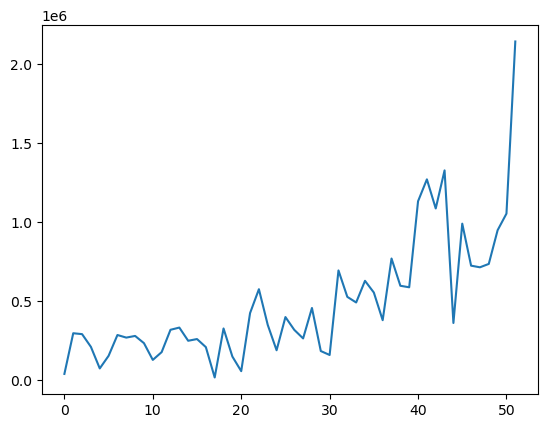

In [21]:
sns.lineplot(pred.to('cpu'), legend=None)

In [22]:
df_plot = df.join(pd.DataFrame(pred.to('cpu'), index=df.tail(-1).index, columns=['predPrice']))

In [28]:
df_plot[df_plot.number=='55']

,address,propertyType,bedrooms,images,hasFloorPlan,location,detailUrl,displayPrice,dateSold,tenure,newBuild,numericPrice,address_1,address_2,number,postcode,prefix,number_idx,predPrice
0,"55, Parma Crescent, London, Greater London SW1...",Flat,2.0,{'imageUrl': 'https://media.rightmove.co.uk/di...,False,"{'lat': 51.4622, 'lng': -0.16433}",https://www.rightmove.co.uk/house-prices/detai...,91200,1995-08-18,Leasehold,False,91200,Parma Crescent,London,55,SW11 1LU,NaN,0,NaN
12,"55, Parma Crescent, London, Greater London SW1...",Flat,2.0,{'imageUrl': 'https://media.rightmove.co.uk/di...,False,"{'lat': 51.4622, 'lng': -0.16433}",https://www.rightmove.co.uk/house-prices/detai...,197500,1998-10-16,Leasehold,False,197500,Parma Crescent,London,55,SW11 1LU,NaN,0,178387.65625
27,"55, Parma Crescent, London, Greater London SW1...",Flat,2.0,{'imageUrl': 'https://media.rightmove.co.uk/di...,False,"{'lat': 51.4622, 'lng': -0.16433}",https://www.rightmove.co.uk/house-prices/detai...,300000,2003-07-04,Leasehold,False,300000,Parma Crescent,London,55,SW11 1LU,NaN,0,319157.59375


<Axes: xlabel='dateSold', ylabel='predPrice'>

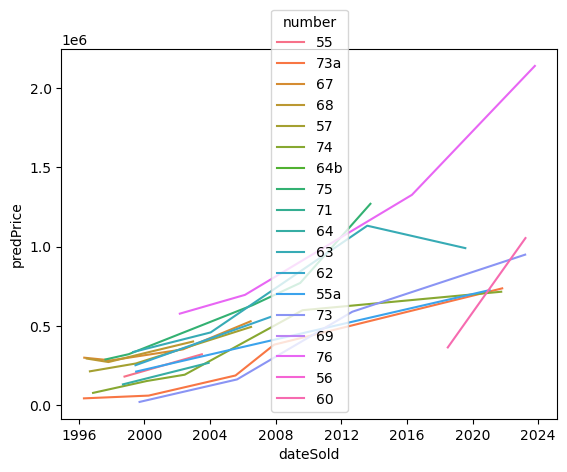

In [25]:
sns.lineplot(data=df_plot, x='dateSold', y='predPrice', hue='number')

<Axes: xlabel='displayPrice', ylabel='predPrice'>

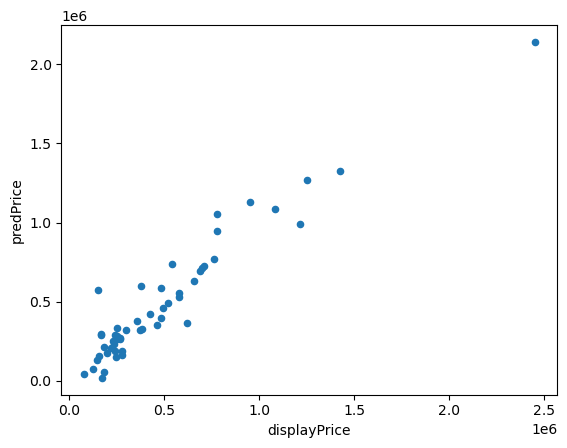

In [26]:
df_plot.plot.scatter(x='displayPrice', y='predPrice')

In [27]:
[(number, (model(
    torch.cat([number_tensor, torch.tensor([[number_to_idx[number]]]).to('cuda:0')]), 
    (torch.tensor([df.displayPrice.tolist()], dtype=torch.float32).T.to('cuda:0') - price_mean) / price_std
)[-1].item() * price_std) + price_mean) for number in number_to_idx]

[('55', tensor(1142112., device='cuda:0')),
 ('55a', tensor(1127658.8750, device='cuda:0')),
 ('56', tensor(1194556.3750, device='cuda:0')),
 ('57', tensor(1186936.6250, device='cuda:0')),
 ('60', tensor(741350.8125, device='cuda:0')),
 ('62', tensor(1177539.1250, device='cuda:0')),
 ('63', tensor(1270033.8750, device='cuda:0')),
 ('64', tensor(1079894.7500, device='cuda:0')),
 ('64b', tensor(1147490.6250, device='cuda:0')),
 ('67', tensor(1251375.3750, device='cuda:0')),
 ('68', tensor(1259411.5000, device='cuda:0')),
 ('69', tensor(1338051., device='cuda:0')),
 ('71', tensor(1192814., device='cuda:0')),
 ('73', tensor(937036.6250, device='cuda:0')),
 ('73a', tensor(959101.6875, device='cuda:0')),
 ('74', tensor(1054737., device='cuda:0')),
 ('75', tensor(1286891.2500, device='cuda:0')),
 ('76', tensor(1456368.1250, device='cuda:0'))]